<a href="https://colab.research.google.com/github/AlexeyTri/MLSeminars/blob/main/MLHSE/Seminar10_LIME_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Интерпретация моделей с помощью LIME и SHAP

SHAP - prediction with feature and ignore feature

$
𝟇_i(p) = ∑_{S \in N/{i}}\frac{|S|!(n-|S| - 1)!}{n!}(p(S ∪ {i} ) - p(S))
$



$p(S ∪ {i} )$ - predicted model with i-featers

$p(S)$ - predict ignore i-features

n - number features

S - random sample features with ignore i-feature



https://habr.com/ru/company/ods/blog/599573/

In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
plt.rcParams['font.size'] = 24

In [6]:
from IPython.core.pylabtools import figsize
import seaborn as sns
sns.set(font_scale = 2)

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer # Univariate imputer for completing missing values with simple strategies.
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree

In [ ]:
!pip install lime

In [79]:
import lime
import lime.lime_tabular

In [11]:
train_features = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_10_lime_shap/training_features.csv')
test_features = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_10_lime_shap/testing_features.csv')
train_labels = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_10_lime_shap/training_labels.csv')
test_labels = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_10_lime_shap/testing_labels.csv')

In [12]:
train_features.head()

Order  Property Id  DOF Gross Floor Area  Year Built  \
0  13276      5849784               90300.0        1950   
1   7377      4398442               52000.0        1926   
2   9479      4665374              104700.0        1954   
3  14774      3393340              129333.0        1992   
4   3286      2704325              109896.0        1927   

   Number of Buildings - Self-reported  Occupancy  Site EUI (kBtu/ft²)  \
0                                    1        100                126.0   
1                                    1        100                 95.4   
2                                    1        100                 40.4   
3                                    1        100                157.1   
4                                    1        100                 62.3   

   Weather Normalized Site Electricity Intensity (kWh/ft²)  \
0                                                5.2         
1                                                4.7         
2                                                3.8         
3                                               16.9         
4                                                3.5         

   Weather Normalized Site Natural Gas Intensity (therms/ft²)  \
0                                                1.2            
1                                                0.9            
2                                                0.3            
3                                                1.1            
4                                                0.0            

   Water Intensity (All Water Sources) (gal/ft²)   Latitude  Longitude  \
0                                          99.41        NaN        NaN   
1                                            NaN  40.835496 -73.887745   
2                                            NaN  40.663206 -73.949469   
3                                            NaN  40.622968 -74.078742   
4                                          28.65  40.782421 -73.972622   

   Community Board  Census Tract  log_Direct GHG Emissions (Metric Tons CO2e)  \
0              NaN           NaN                                     6.088818   
1              3.0         161.0                                     5.384036   
2              9.0         329.0                                     5.017280   
3              1.0          27.0                                     6.510853   
4              7.0         165.0                                     6.123589   

   log_Water Intensity (All Water Sources) (gal/ft²)  Borough_Staten Island  \
0                                           4.599253                      0   
1                                                NaN                      0   
2                                                NaN                      0   
3                                                NaN                      1   
4                                           3.355153                      0   

   Largest Property Use Type_Adult Education  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   Largest Property Use Type_Automobile Dealership  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   Largest Property Use Type_Bank Branch  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   Largest Property Use Type_College/University  \
0                                             0   
1                                             0   


In [27]:
imputer = SimpleImputer(strategy='median')

imputer.fit(train_features)
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

imputer.fit(train_labels)
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [19]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [29]:
%%time
model = GradientBoostingRegressor(max_depth=5, n_estimators=800, min_samples_leaf=6, min_samples_split=6, random_state=42, max_features=None)

model.fit(X, y)
model_predict = model.predict(X_test)

print('Final model performans on test: MAE = %0.4f' % mae(y_test, model_predict))

Final model performans on test: MAE = 9.4122
CPU times: user 28.6 s, sys: 19.9 ms, total: 28.6 s
Wall time: 29.1 s


Встроенные в деревянные модели методы feature_importance_ показывают важность признаков для модели, но не показывают, какой вклад вносят признаки в ответ.

Для некоторых моделей даже нет базового готового решения, как посчитать важность (например, для KNN).

In [33]:
feature_results = pd.DataFrame({
    'feature': list(train_features.columns),
    'importance': model.feature_importances_}
)

In [34]:
feature_results = feature_results.sort_values('importance', ascending=False).reset_index(drop=True)
feature_results.head()

feature  importance
0                                Site EUI (kBtu/ft²)    0.605408
1  Weather Normalized Site Electricity Intensity ...    0.140072
2      Largest Property Use Type_Multifamily Housing    0.074995
3                                        Property Id    0.026007
4                               DOF Gross Floor Area    0.018150

Text(0.5, 1.0, 'Feature Importances from Random Forest')

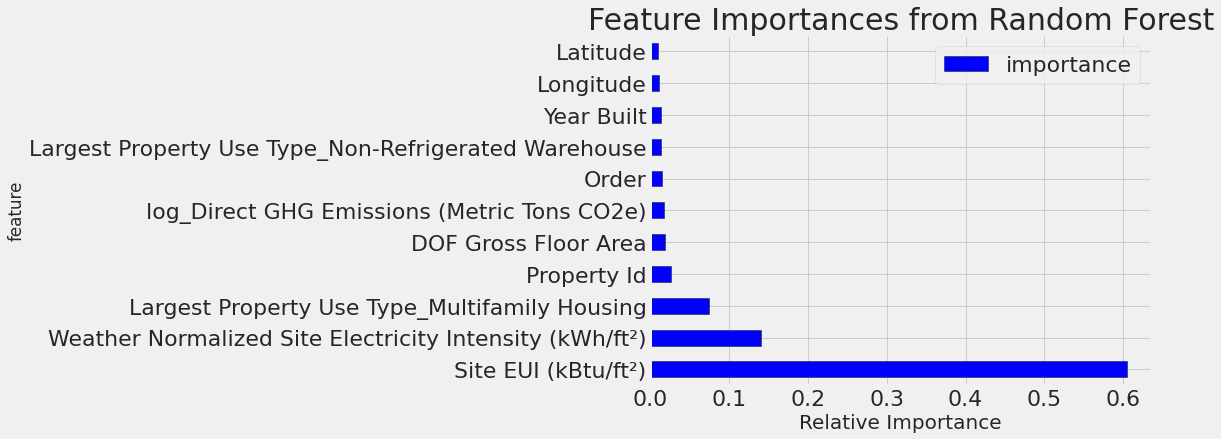

In [38]:
figsize(8,6)
plt.style.use('fivethirtyeight')

feature_results.loc[:10,:].plot(x='feature', y='importance',
                                kind='barh', edgecolor='k',
                                color='blue')
plt.xlabel('Relative Importance', size=20)
plt.title('Feature Importances from Random Forest', size=30)

In [57]:
most_important_features = feature_results['feature'][:10]

indices = [list(train_features.columns).index(x) for x in most_important_features]

X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

X_reduced.shape, X_test_reduced.shape

((6622, 10), (2839, 10))

In [58]:
lr = LinearRegression()
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

mae(y_test, lr_full_pred), mae(y_test, lr_reduced_pred)

(13.465092871687567, 14.33383120536714)

In [59]:
# Create the model with the same hyperparamters
model_reduced = GradientBoostingRegressor(max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE = 9.9360


In [60]:
residuals = abs(model_reduced_pred - y_test)

In [62]:
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [80]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

In [74]:
print(model_reduced.predict(wrong.reshape(1, -1)))
print(y_test[np.argmax(residuals)])

[23.52829436]
100.0


In [81]:
wrong_exp = explainer.explain_instance(data_row=wrong,
                                       predict_fn = model_reduced.predict)

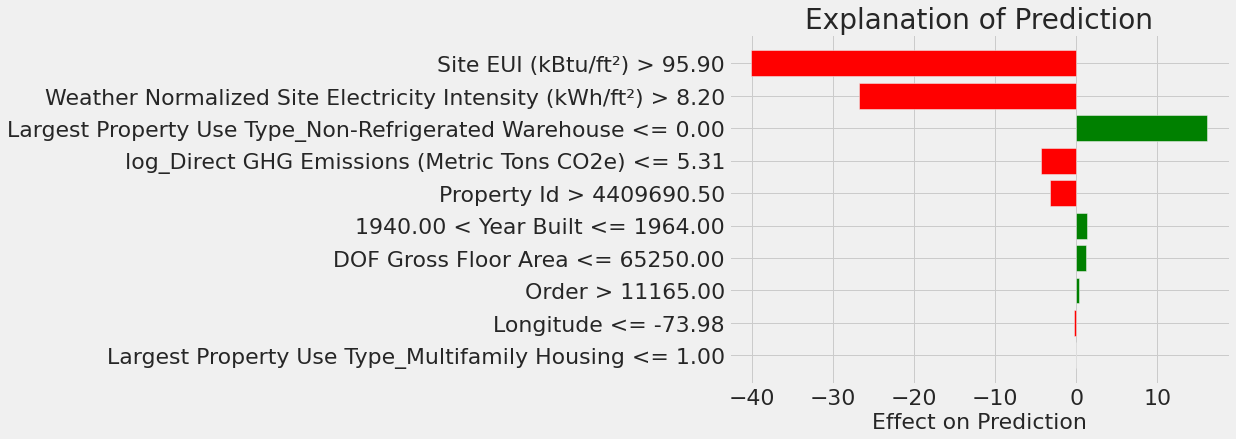

In [82]:
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [83]:
wrong_exp.show_in_notebook(show_predicted_value=False)

Prediction: 78.9999
Actual Value: 79.0000


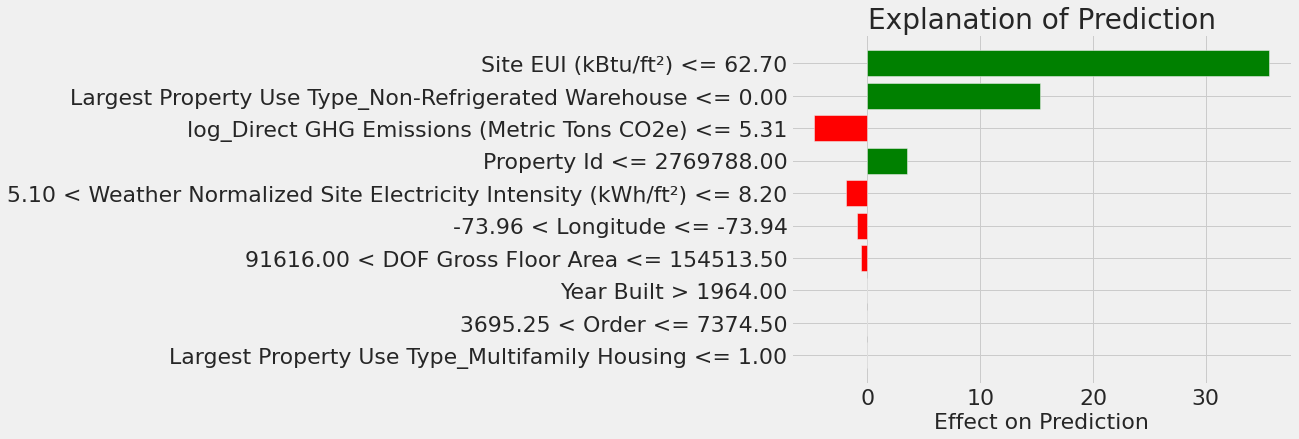

In [84]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [85]:
right_exp.show_in_notebook(show_predicted_value=False)

In [98]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 32.2 MB/s eta 0:00:00


In [99]:
import shap
shap.initjs()

In [100]:
gb_explainer = shap.KernelExplainer(model_reduced.predict, X_test_reduced[1000:1100])
gb_shap_values = gb_explainer.shap_values(X_test_reduced[1000:1100])

  0%|          | 0/100 [00:00<?, ?it/s]

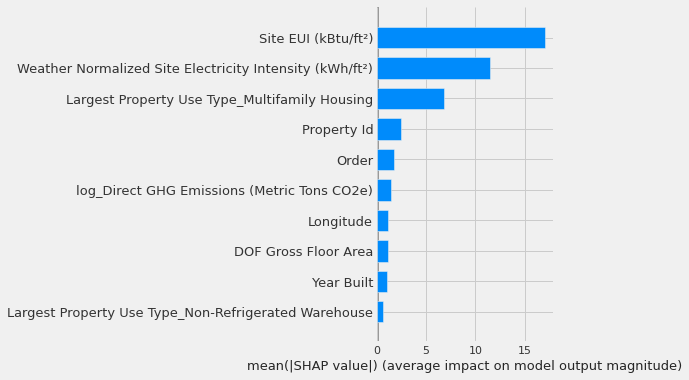

In [101]:
shap.summary_plot(gb_shap_values, X_test_reduced[1000:1100], plot_type="bar", feature_names = list(most_important_features))

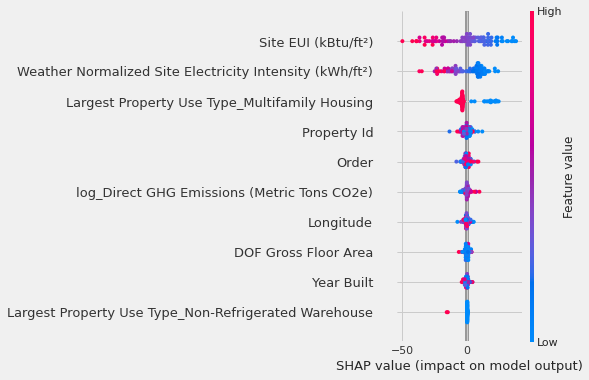

In [102]:
shap.summary_plot(gb_shap_values, X_test_reduced[1000:1100], feature_names = list(most_important_features))